# Assignment: Credit_Card_Ensemble Modeling Techniques

## Fin Tech HW Session 11 Classification Modeling
### Student: Nate Walker

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Initial imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image


In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [9]:
# Load the data
file_path = Path('C:/FinTech/LoanStats_2019Q1.csv/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [10]:
# Shape of the Dataframe
# There are 68k rows of data by 86 columns
df.shape

(68817, 86)

In [12]:
df.count().sample(11) # Count of the number of items per variable
#df.count().tail(11)

next_pymnt_d             68817
pymnt_plan               68817
num_op_rev_tl            68817
mths_since_rcnt_il       68817
mths_since_recent_bc     68817
open_act_il              68817
acc_now_delinq           68817
mo_sin_rcnt_rev_tl_op    68817
initial_list_status      68817
open_rv_12m              68817
num_il_tl                68817
dtype: int64

In [13]:
# Id the variable types in the dataframe
df["loan_status"].dtypes
# The loan status is an object

dtype('O')

In [14]:
# Count the two categories in the loan status column
df["loan_status"].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [18]:
df[df == 0].count()   # Count the number of records that have 0's

loan_amnt                         0
int_rate                          0
installment                       0
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
dti                               6
delinq_2yrs                   59117
inq_last_6mths                43254
open_acc                          0
pub_rec                       60243
revol_bal                       401
total_acc                         0
initial_list_status               0
out_prncp                       110
out_prncp_inv                   110
total_pymnt                     176
total_pymnt_inv                 176
total_rec_prncp                 183
total_rec_int                   180
total_rec_late_fee            68723
recoveries                    68817
collection_recovery_fee       68817
last_pymnt_amnt                 178
next_pymnt_d                

In [ ]:
df.isnull().sum()  # Check for missing values
# no missing values

## Binary Encode the dataframe

In [20]:
# Create the Dummy Codes for the dataframe
# Binary encoding using Pandas (multiple columns)
loans_binary_encoded = pd.get_dummies(df, columns=["issue_d","home_ownership","initial_list_status", "verification_status","pymnt_plan","next_pymnt_d","hardship_flag","application_type","debt_settlement_flag"])
loans_binary_encoded.head()
loans_binary_encoded.sample(5)
# Note: data dictionary: 0 - not de

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,hardship_flag_N,application_type_Individual,application_type_Joint App,debt_settlement_flag_N
62906,12000.0,0.1180,397.43,60000.0,low_risk,34.10,0.0,0.0,10.0,0.0,...,0,0,1,1,1,0,1,0,1,1
64038,10900.0,0.1180,361.00,70070.0,low_risk,17.85,0.0,2.0,18.0,0.0,...,0,1,0,1,0,1,1,1,0,1
39868,16000.0,0.0881,507.39,120000.0,low_risk,13.39,1.0,1.0,15.0,0.0,...,1,0,0,1,1,0,1,1,0,1
33117,2000.0,0.1797,72.28,46200.0,low_risk,28.18,0.0,0.0,6.0,0.0,...,1,0,0,1,0,1,1,1,0,1
6003,10000.0,0.0646,306.31,70000.0,low_risk,28.20,0.0,0.0,18.0,1.0,...,1,0,0,1,0,1,1,1,0,1


## Encode the Target Variable

In [21]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["loan_status_code"] = lb_make.fit_transform(df["loan_status"])
# create new column loan_status_code and encode the columns as 0 & 1's

df[["loan_status", "loan_status_code"]].head(11)

df[["loan_status", "loan_status_code"]].sample(10)

,loan_status,loan_status_code
12708,low_risk,1
17604,low_risk,1
6294,low_risk,1
23279,low_risk,1
11193,low_risk,1
44584,low_risk,1
51724,low_risk,1
35092,low_risk,1
32946,low_risk,1
22444,low_risk,1


In [23]:
# Drop the loan status column from the encoded loans df
loans_encoded = loans_binary_encoded.drop(['loan_status'],axis=1)
loans_encoded.head()
loans_encoded.tail()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,hardship_flag_N,application_type_Individual,application_type_Joint App,debt_settlement_flag_N
68812,10000.0,0.1502,346.76,26000.0,9.60,0.0,0.0,9.0,0.0,2684.0,...,0,1,0,1,0,1,1,1,0,1
68813,12000.0,0.2727,368.37,63000.0,29.07,0.0,0.0,8.0,0.0,13314.0,...,1,0,0,1,0,1,1,1,0,1
68814,5000.0,0.1992,185.62,52000.0,14.86,0.0,0.0,5.0,1.0,3715.0,...,0,1,0,1,0,1,1,1,0,1
68815,40000.0,0.0646,1225.24,520000.0,9.96,0.0,1.0,21.0,0.0,59529.0,...,0,0,1,1,0,1,1,1,0,1
68816,16000.0,0.1131,350.36,72000.0,7.02,2.0,0.0,12.0,1.0,11882.0,...,0,0,1,1,0,1,1,1,0,1


# Split the Data into Training and Testing

In [24]:
# Create our features
X = loans_encoded

# Create our target
# YOUR CODE HERE
y = df['loan_status_code']

In [26]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,hardship_flag_N,application_type_Individual,application_type_Joint App,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.478007,0.373992,0.148001,1.0,0.383161,0.616839,1.0,0.860340,0.139660,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.499520,0.483865,0.355104,0.0,0.486161,0.486161,0.0,0.346637,0.346637,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.0,1.000000,0.000000,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.0,1.000000,0.000000,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0


In [27]:
# Check the balance of our target values
y.value_counts()

1    68470
0      347
Name: loan_status_code, dtype: int64

In [28]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE
X = loans_encoded

# Create our target
# y = # YOUR CODE HERE
y = df["loan_status_code"].values.reshape(-1, 1)
y[:5]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(loans_encoded, y, random_state=1)

In [31]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [32]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [33]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [39]:
# Resample the training data with the RandomOversampler
# Fit a Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=1)
brf.fit(X_train, y_train)
#n-estimators: the number of trees in your forrest (i.e.: 64, 128, 500)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=2, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=1000,
                               n_jobs=None, oob_score=False, random_state=1,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [40]:
# Print the imbalanced classification report
y_pred_rf = brf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.04      0.62      0.91      0.07      0.75      0.55       101
          1       1.00      0.91      0.62      0.95      0.75      0.58     17104

avg / total       0.99      0.91      0.63      0.94      0.75      0.58     17205



In [44]:
# Resample the training data with the RandomOversampler
# YOUR CODE HERE
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({1: 51366, 0: 51366})

In [10]:
# Resample the training data with the RandomOversampler
# YOUR CODE HERE
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=1, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [46]:
# Display the confusion matrix
# YOUR CODE HERE
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[   68,    33],
       [ 6894, 10210]], dtype=int64)

In [47]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.6351018579407053

In [11]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

0.7855052723466922

In [12]:
# Display the confusion matrix
# YOUR CODE HERE

array([[   68,    33],
       [ 1749, 15355]])

In [48]:
# Print the imbalanced classification report
# YOUR CODE HERE
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.01      0.67      0.60      0.02      0.63      0.40       101
          1       1.00      0.60      0.67      0.75      0.63      0.40     17104

avg / total       0.99      0.60      0.67      0.74      0.63      0.40     17205



In [49]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

In [50]:
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)


[(0.07287700286069668, 'last_pymnt_amnt'),
 (0.06751713427252345, 'total_rec_int'),
 (0.06466324247868388, 'total_rec_prncp'),
 (0.06191326789024014, 'total_pymnt_inv'),
 (0.05904305258007522, 'total_pymnt'),
 (0.02161376528979063, 'installment'),
 (0.020413931135294185, 'out_prncp_inv'),
 (0.018780557489398386, 'out_prncp'),
 (0.017427350602075353, 'dti'),
 (0.01596902143567539, 'max_bal_bc'),
 (0.015263796980640856, 'mo_sin_old_rev_tl_op'),
 (0.015115238109730115, 'loan_amnt'),
 (0.01467337465097961, 'revol_bal'),
 (0.014422862317719123, 'bc_open_to_buy'),
 (0.0143620017808363, 'mo_sin_old_il_acct'),
 (0.01430579240888736, 'total_bal_ex_mort'),
 (0.01408021770877473, 'tot_cur_bal'),
 (0.014066560493594211, 'tot_hi_cred_lim'),
 (0.013933586266157517, 'total_bal_il'),
 (0.013732146363586141, 'avg_cur_bal'),
 (0.013333116618196755, 'bc_util'),
 (0.012908718244298376, 'total_bc_limit'),
 (0.012900002699768296, 'total_rev_hi_lim'),
 (0.012830227799058494, 'annual_inc'),
 (0.01277224508281

## The Values per the Assignment

In [14]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE

loan_amnt: (0.09175752102205247)
int_rate: (0.06410003199501778)
installment: (0.05764917485461809)
annual_inc: (0.05729679526683975)
dti: (0.05174788106507317)
delinq_2yrs: (0.031955619175665397)
inq_last_6mths: (0.02353678623968216)
open_acc: (0.017078915518993903)
pub_rec: (0.017014861224701222)
revol_bal: (0.016537957646730293)
total_acc: (0.016169718411077325)
out_prncp: (0.01607049983545137)
out_prncp_inv: (0.01599866290723441)
total_pymnt: (0.015775537221600675)
total_pymnt_inv: (0.01535560674178928)
total_rec_prncp: (0.015029265003541079)
total_rec_int: (0.014828006488636946)
total_rec_late_fee: (0.01464881608833323)
recoveries: (0.014402430445752665)
collection_recovery_fee: (0.014318832248876989)
last_pymnt_amnt: (0.013519867193755364)
collections_12_mths_ex_med: (0.013151520216882331)
policy_code: (0.013101578263049833)
acc_now_delinq: (0.012784600558682344)
tot_coll_amt: (0.012636608914961465)
tot_cur_bal: (0.012633464965390648)
open_acc_6m: (0.012406321468566728)
open_act_

### Easy Ensemble AdaBoost Classifier

In [61]:
# Train the Classifier
# YOUR CODE HERE
# Resample the training data with the RandomOversampler
# Fit a EasyEnsemble Classifier
from imblearn.ensemble import EasyEnsembleClassifier
Adabrf = EasyEnsembleClassifier(n_estimators=1000, random_state=1)
Adabrf.fit(X_train, y_train)
#n-estimators: the number of trees in your forrest (i.e.: 64, 128, 500)

EasyEnsembleClassifier(base_estimator=None, n_estimators=1000, n_jobs=None,
                       random_state=1, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)

In [65]:
# Train the Classifier
# YOUR CODE HERE
# Resample the training data with the RandomOversampler
# Fit a Random Forest Classifier
from imblearn.ensemble import EasyEnsembleClassifier
Adabrf = EasyEnsembleClassifier(n_estimators=1500, random_state=1)
Adabrf.fit(X_train, y_train)
#n-estimators: the number of trees in your forrest (i.e.: 64, 128, 500)

EasyEnsembleClassifier(base_estimator=None, n_estimators=1500, n_jobs=None,
                       random_state=1, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)

In [66]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.6351018579407053

In [16]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

0.9316600714093861

In [67]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[   68,    33],
       [ 6894, 10210]], dtype=int64)

In [17]:
# Display the confusion matrix
# YOUR CODE HERE

array([[   93,     8],
       [  983, 16121]])

In [62]:
y_pred_rf = Adabrf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.09      0.92      0.95      0.17      0.93      0.87       101
          1       1.00      0.95      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.95      0.92      0.97      0.93      0.87     17205



In [18]:
# Print the imbalanced classification report
# YOUR CODE HERE

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



## Gardient Boost Model

## Choose the Best Learning Rate

In [53]:
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train_scaled, y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.996
Accuracy score (validation): 0.995

Learning rate:  0.1
Accuracy score (training): 0.996
Accuracy score (validation): 0.995

Learning rate:  0.25
Accuracy score (training): 0.996
Accuracy score (validation): 0.995

Learning rate:  0.5
Accuracy score (training): 0.996
Accuracy score (validation): 0.995

Learning rate:  0.75
Accuracy score (training): 0.996
Accuracy score (validation): 0.995

Learning rate:  1
Accuracy score (training): 0.967
Accuracy score (validation): 0.966



## Create the Boosting Classifier

In [54]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.75,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

,Prediction,Actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


## Evaluate the Model

In [55]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.9950014530659692


In [56]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,29,72
Actual 1,14,17090


In [57]:
# Generate classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.29      0.40       101
           1       1.00      1.00      1.00     17104

    accuracy                           1.00     17205
   macro avg       0.84      0.64      0.70     17205
weighted avg       0.99      1.00      0.99     17205



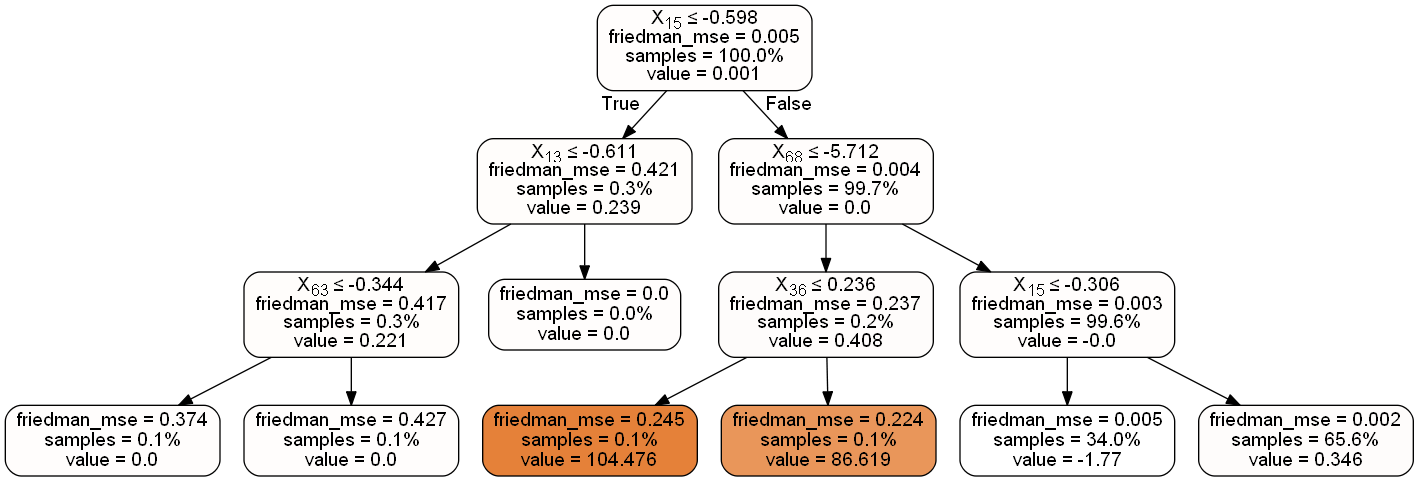

In [60]:
# Graph tree
dot_data = tree.export_graphviz(
    classifier.estimators_[9, 0],
    out_file=None, filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
# The treee splits on the'X15' variable as credit risk (true) or no credit risk(false)
# the tree further splits on the most important variables (X68, X36) and is only 3 layers deep.
# This model is not a final model only because it did not use a balanced score classifier
# This model is a poor model to predict loan defaults.
